In [8]:
import sys
import os
os.chdir('/mnt/cimec-storage6/users/nicola.debole/home/CQA')
sys.path.append('/mnt/cimec-storage6/users/nicola.debole/home/CQA')

def format_concept(s):
    # replace - with ' '
    # replace , with ' '
    # only one space between words
    s = s.lower()
    s = s.replace("-", " ")
    s = s.replace(",", " ")
    s = s.replace(".", " ")
    s = s.replace("(", " ")
    s = s.replace(")", " ")
    if s[:2] == "a ":
        s = s[2:]
    elif s[:3] == "an ":
        s = s[3:]

    # remove trailing and leading spaces
    s = " ".join(s.split())
    return s
def get_concepts(concept_file: str, filter_file = None):
    with open(concept_file) as f:
        concepts = f.read().split("\n")

    # remove repeated concepts and maintain order
    concepts = list(dict.fromkeys([format_concept(concept) for concept in concepts]))

    # check for filter file
    if filter_file and os.path.exists(filter_file):
        with open(filter_file) as f:
            to_filter_concepts = f.read().split("\n")
        to_filter_concepts = [format_concept(concept) for concept in to_filter_concepts]
        concepts = [concept for concept in concepts if concept not in to_filter_concepts]
    return concepts

dataset_name = "shapes3d"
raw_concepts = get_concepts("./data/concepts/shapes3d/shapes3d.txt")
n_px = 220

In [12]:
from matplotlib import pyplot as plt

def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2))
    ax.text(x0, y0, label)

def plot_annotations(image_pil: Image.Image, annotations) -> plt.Figure:
    """
    Plot annotations on image

    Args:
        image_pil (Image.Image): The PIL image
        annotations (List[Dict]): The annotations to plot in the following format:
            - logits: The logits associated with each token of the concept.
            - score: The perplexity of the concept.
            - concept: The concept associated with the bounding box.
            - bbox: The bounding box coordinates.

    Returns:
        plt.Figure: The figure containing the image with annotations.
    """
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image_pil)
   
    for annotation in annotations:
        if annotation["logit"] > 0.3:
           show_box(annotation["box"], plt.gca(), f"{annotation['label']} : {annotation['logit']:.3f}")
    plt.axis("off")
    return fig

In [15]:



import torch
import json
from PIL import Image
import numpy as np
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC
def _convert_image_to_rgb(image):
    return image.convert("RGB")

from datasets import get_dataset

t = Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def get_bbox_iou(boxA, boxB):
    # Source: https://gist.github.com/meyerjo/dd3533edc97c81258898f60d8978eddc
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

class ConceptDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset_name: str,
        torch_dataset: torch.utils.data.Dataset,
        concepts = None,
        split_suffix="train",
        label_dir: str = "outputs",
        confidence_threshold: float = 0.10,
        preprocess=None,
        crop_to_concept_prob: bool = 0.0,
        overlap_iou_threshold: float = 0.5,
        concept_only=False
    ):
        self.torch_dataset = torch_dataset
        self.concepts = concepts
        self.dir = f"{label_dir}/{dataset_name}_{split_suffix}"
        self.confidence_threshold = confidence_threshold
        self.preprocess = preprocess
        self.overlap_iou_threshold = overlap_iou_threshold
        self.concept_only = concept_only
        # Return cropped image containing a single concept
        # with probability `crop_to_concept_prob`
        self.crop_to_concept_prob = crop_to_concept_prob

    def __len__(self):
        return len(self.torch_dataset)

    def __getitem__(self, idx):
        if self.concept_only:
            return 0, self._get_concept(idx), 0 # 0 is placeholder
        prob = np.random.rand()
        if prob < self.crop_to_concept_prob:
            try:
                return self.__getitem__per_concept(idx)
            except Exception as e:
                print(f"Failed to get item {idx} per concept: {e}")

        return self.__getitem__all(idx)

    def __getitem__per_concept(self, idx):
        image, _, target = self.torch_dataset[idx]

        # return 1 hot vector of concepts
        data = self._get_data(idx)

        bbxs = data[1:]
        bbxs = [bbx for bbx in bbxs if bbx["logit"] > self.confidence_threshold]
        for bbx in bbxs:
            bbx["label"] = format_concept(bbx["label"])

        # get mapping of concepts to a random bounding box containing the concept
        concept_bbx_map = []
        for concept_idx, concept in enumerate(self.concepts):
            _, matched_bbxs = self._find_in_list(concept, bbxs)
            if len(matched_bbxs) > 0:
                concept_bbx_map.append((concept_idx, matched_bbxs[np.random.randint(0, len(matched_bbxs))]))

        # get one hot vector of concepts
        concept_one_hot = torch.zeros(len(self.concepts), dtype=torch.float)
        if len(concept_bbx_map) > 0:
            # randomly pick a concept and its bounding box
            random_concept_idx, random_bbx = concept_bbx_map[np.random.randint(0, len(concept_bbx_map))]
            concept_one_hot[random_concept_idx] = 1.0
            image = image.crop(random_bbx["box"])

            # mark concepts with high overlap with the selected concept as 1
            for bbx in bbxs:
                if bbx["label"] == random_bbx["label"]:
                    continue
                else:
                    iou = get_bbox_iou(random_bbx["box"], bbx["box"])
                    try:
                        if iou > self.overlap_iou_threshold:
                            concept_idx = self.concepts.index(bbx["label"])
                            concept_one_hot[concept_idx] = 1.0
                            # logger.debug(f"Marking {bbx['concept']} as 1 due to overlap with {random_bbx['concept']}")
                    except ValueError:
                        continue

        # preprocess image
        if self.preprocess:
            image = self.preprocess(image)

        return image, concept_one_hot, target

    def __getitem__all(self, idx):
        image, _, target = self.torch_dataset[idx]

        # get raw data
        data = self._get_data(idx)

        # get one hot vector of concepts
        bbxs = data[1:]
        bbxs = [bbx for bbx in bbxs if bbx["logit"] > self.confidence_threshold]
        for bbx in bbxs:
            bbx["label"] = format_concept(bbx["label"])
        # get one hot vector of concepts
        concept_one_hot = [1 if self._find_in_list(concept, bbxs)[0] else 0 for concept in self.concepts]
        concept_one_hot = torch.tensor(concept_one_hot, dtype=torch.float)

        # preprocess image
        if self.preprocess:
            image = self.preprocess(image)

        return image, concept_one_hot, target
    
    def _get_concept(self, idx):
        # return 1 hot vector of concepts
        data = self._get_data(idx)

        # get one hot vector of concepts
        bbxs = data[1:]
        bbxs = [bbx for bbx in bbxs if bbx["logit"] > self.confidence_threshold]
        for bbx in bbxs:
            bbx["label"] = format_concept(bbx["label"])
        
        # get one hot vector of concepts
        concept_one_hot = [1 if self._find_in_list(concept, bbxs)[0] else 0 for concept in self.concepts]
        concept_one_hot = torch.tensor(concept_one_hot, dtype=torch.float)
        #print(concept_one_hot)
        return concept_one_hot

    def _find_in_list(self, concept: str, bbxs):
        #for bb in bbxs:
        #    print(bb["label"].strip().replace(" ","_"), "- C:", concept.strip().replace(" ","_"))
        # randomly pick a bounding box
        # .replace(" _","_").replace(" _","_")
        matched_bbxs = [bbx for bbx in bbxs if concept.strip().replace(" ","_") == bbx["label"].strip().replace(" ","_")]
        return len(matched_bbxs) > 0, matched_bbxs

    def _get_data(self, idx):
        data_file = f"{self.dir}/{idx}.json"
        with open(data_file, "r") as f:
            data = json.load(f)
        return data

    def get_annotations(self, idx: int):
        return self._get_data(idx)[1:]
    
    ''' asdgteyt34tdfs
    def visualize_annotations(self, idx: int):
        image_pil = self.torch_dataset[idx][0]
        annotations = self._get_data(idx)[1:]
        fig = plot_annotations(image_pil, annotations)
        fig.show()

    def plot_annotations(self, idx: int, annotations: List[Dict[str, Any]]):
        image_pil = self.torch_dataset[idx][0]
        fig = plot_annotations(image_pil, annotations)
        fig.show()
    '''
    def get_image_pil(self, idx: int):
        return self.torch_dataset[idx][0]

    def get_target(self, idx):
        _, target = self.torch_dataset[idx]
        return target 
    def visualize_annotations(self, idx: int):
        image_pil = self.torch_dataset[idx][0]
        annotations = self._get_data(idx)[1:]
        fig = plot_annotations(image_pil, annotations)
        fig.show()

concept_dataset = ConceptDataset(
                    dataset_name,
                    get_dataset(dataset_name, split="val"),
                    raw_concepts,
                    split_suffix="val",
                    preprocess=t,
                    confidence_threshold=0.15,
                    crop_to_concept_prob=0,
                    label_dir="./data/VLG_annotations",
                    concept_only=False
                )

2025-02-07 13:35:49.517 | DEBUG    | datasets:get_dataset:23 - Getting dataset shapes3d with kwargs {'split': 'val'}


Class Name:  0
red object: 1.0
pill shaped object: 1.0


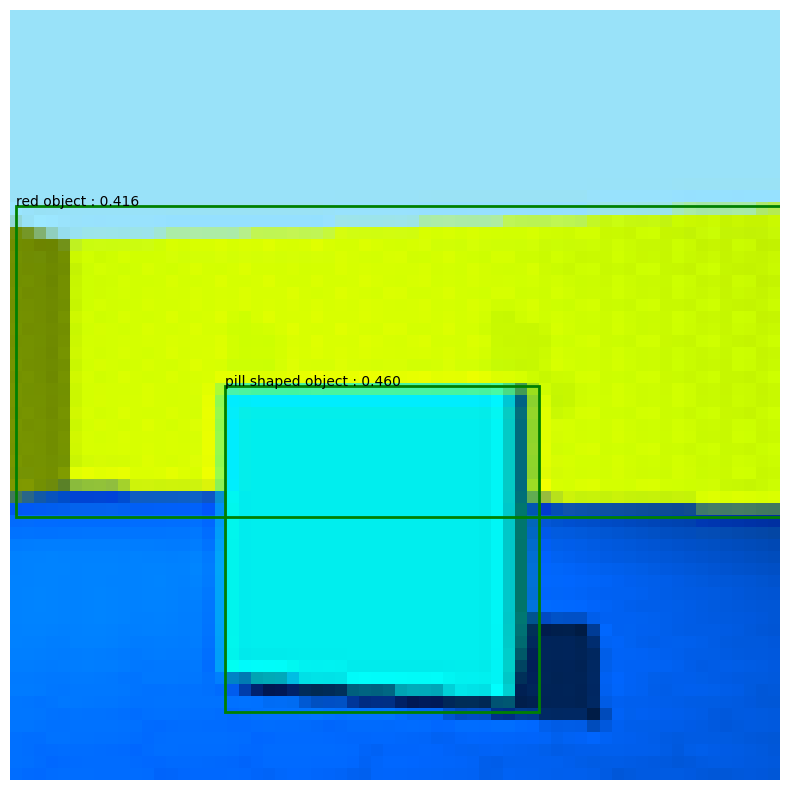

In [16]:
idx = 16
concept_dataset.visualize_annotations(idx)
image, concepts_one_hot, class_idx = concept_dataset[idx]
print("Class Name: ", 0)
_ = [print(f"{concept}: {score}") for concept, score in zip(raw_concepts, concepts_one_hot) if score == 1]